# High Value Customer Identification

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )


## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras ) 
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra
        #
        - Custo:
            - Baixo número de devoluções
        #
        - Experiência:  
            - Média alta de avaliações

#
2. Quantos clientes farão parte do grupo?

    - Número de clientes
    - % em relação ao total de clientes

#
3. Quais as principais características desses clientes?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
    #
    - Escrever os principais comportamentos de compra dos clientes ( métricas de negócio )
        - Vide acima

#
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

#
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )

#
6. Quais as condições para uma pessoa ser elegível ao Insiders ?

    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

#
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

#
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B

#
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [2]:
import pickle
import warnings
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns

from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from plotly import express as px

import umap.umap_ as umap

from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [3]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignore future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()

In [4]:
notebook_settings()

## 0.2 Load Data

In [5]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', low_memory=False, encoding='cp1252')

# 1.0 Descrição dos dados

In [6]:
df1 = data_raw.copy()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN


## 1.1 Rename Columns

In [7]:
# Drop error column
df1 = df1.drop(columns=['Unnamed: 8'], axis=1)

cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
              'unit_price', 'customer_id', 'country']

df1.columns = cols_news

## 1.2 Data Dimension

In [8]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 541909
number of cols: 8


## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [11]:
# Separate df into NA and not NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

# create df for reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# create sintetics customers id
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge results of recerence into original df
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True)

In [12]:
# Description column is gonna be droped
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Types

In [13]:
# change invoice_date into date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# change customer_id into int 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
m = pd.concat([d1, d2]).T
m = m[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
m

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.000,80995.000,161990.000,9.552,3.000,218.081,-0.264,119769.160
unit_price,-11062.060,38970.000,50032.060,4.611,2.080,96.760,186.507,59005.719
customer_id,12346.000,22709.000,10363.000,16688.840,16249.000,2911.411,0.487,-0.804


- Valores grandes e negativos em quantity (devoluções?)
- Valores negativos em preço unitário (devolução/promoção?)

### 1.7.2 Categorical Attributes

In [17]:
# Count unique itens per columns
count_ = cat_attributes.apply(lambda x: x.unique().shape).T.rename(columns={0:'count'})
count_

,count
invoice_no,25900
stock_code,4070
description,4224
country,38


In [18]:
# Verify 'invoice no' with caracters
df_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]

print(f'Total numbers of invoices: {len(df1["invoice_no"])}')
print(f'Total numbers of negative invoices: {len(df_invoice)}')
print(f'Total number of negative quantity: {len(df_invoice[df_invoice["quantity"] < 0])}')

# Invoices with positives values
df_invoice[df_invoice['quantity'] >= 0]

Total numbers of invoices: 541909
Total numbers of negative invoices: 9291
Total number of negative quantity: 9288


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.060,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21499


In [19]:
# Verify stock code with caracters
df_stock = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]
df_stock_cat = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

print(f'Total numbers of stock code: {len(df1["stock_code"])}')
print(f'Total numbers of stock code with any categorical: {len(df_stock)}')
print(f'Total numbers of stock code with only categorical: {len(df_stock_cat)}')

Total numbers of stock code: 541909
Total numbers of stock code with any categorical: 54873
Total numbers of stock code with only categorical: 2759


In [20]:
# Analysis only codes
df_stock_cat['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [21]:
# Distribuiton for each country
total = cat_attributes['country'].shape[0]
cat_attributes['country'].value_counts().apply(lambda x: 100*(x/total)).head(10)

United Kingdom   91.432
Germany           1.752
France            1.579
EIRE              1.512
Spain             0.467
Netherlands       0.438
Belgium           0.382
Switzerland       0.369
Portugal          0.280
Australia         0.232
Name: country, dtype: float64

- **Invoice no** 

        - Problema: Valores com alguma letra referem a estorno ou ajustes
        - Solução: retirar itens com quantidades negativas, os mesmos se referem aos estornos e ajustes

- **Stock code**
        
        - Problemas: Códigos com números e letras
        - Solução: Retirar códigos com apenas letras, com excessão de 2 tipos (DCGSSBOY, DCGSSGIRL), os demais são estorno, ajustes, taxas e serviços não relacionados diretamente ao cliente.

- **Description**

        - Solução: Descartar a coluna
        - Justificativa: A feature não descreve até o momento nada relacionada a segmentação de clientes.

# 2.0 Filtragem de variáveis

In [22]:
df2 = df1.copy()

## 2.1 Seleção das colunas

In [23]:
df2.drop(columns='description', axis=1, inplace=True)

## 2.2 Filtragem das linhas

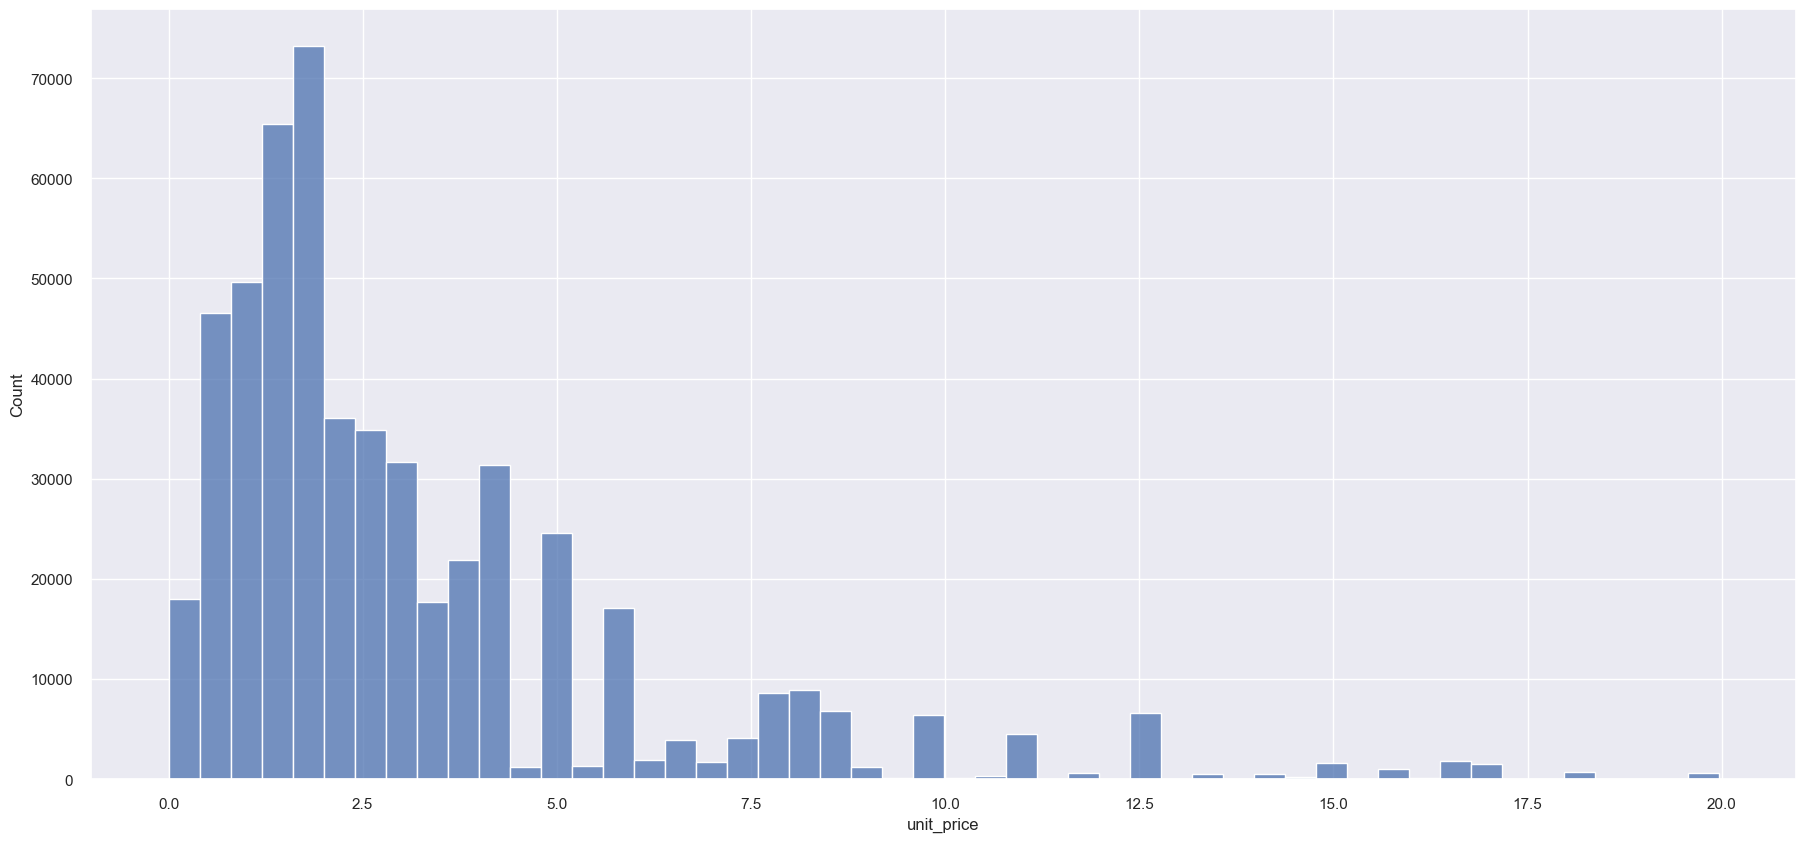

In [24]:
aux = df2[(df2['unit_price'] > 0) & (df2['unit_price'] < 20)]
sns.histplot(x='unit_price', bins=50, data=aux);

In [25]:
# remove unit_price bellow 0.030 (bellow this consider promo or return)
df2 = df2[df2['unit_price'] > 0.030]

# remove stock code with only categoricals variables (expect DCGSSBOY and DCGSSGIRL)
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 
                                    'm', 'PADS', 'B', 'CRUK'])]

# removes information from unidentified countries
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# separate dataframes for purchases and refunds
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]

# 3.0 Feature Engineering

In [26]:
df3 = df2.copy()

Ideas
- Moving Average - 7d, 14d, 30d
- Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
- Average Financial
- Basket Size * Price - Quantidade de preços por cesta

## 3.1 MindMap Hypothesis

## 3.2 Lista final de hipóteses

## 3.3 Feature Engineering

In [27]:
# -------------------- Features based on RFM Model ---------------
# make data frame for reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) | quantity * price
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


# Monetary - Total buys from each customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

In [28]:
# Recency - Last day purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace=True)
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

In [29]:
# Quantity of purchased
df_qnt = (df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'invoice_no': 'qty_invoices'}))

df_ref = pd.merge(df_ref, df_qnt, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

In [30]:
# Quantity of items purchased
df_qnt_items = (df2_purchases[['customer_id', 'quantity']].groupby('customer_id')
                                             .sum().reset_index()
                                             .rename(columns={'quantity': 'qty_items'}))

df_ref = pd.merge(df_ref, df_qnt_items, on='customer_id', how='left')

df_ref.isna().sum()                                             

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
dtype: int64

In [31]:
# Quantity of products purchased
df_qnt_products = (df2_purchases[['customer_id', 'stock_code']].groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'stock_code': 'qty_products'}))

df_ref = pd.merge(df_ref, df_qnt_products, on='customer_id', how='left')

df_ref.isna().sum()   

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
dtype: int64

In [32]:
# Avg ticket - average purchases per customer
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index()
df_avg_ticket.columns = ['customer_id', 'avg_ticket']
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
avg_ticket       91
dtype: int64

In [33]:
# Mean of recency days
df_aux = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # colect next customer id 
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift() # colect next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1) 

df_aux.drop(columns=['invoice_date', 'next_customer_id', 'next_invoice_date'], inplace=True)

# average recency
df_avg_recency = df_aux.dropna().groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency, how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

In [34]:
# Frequency - total number of purchases in a period
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'), min_ = ('invoice_date', 'min'), 
                                                                days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1), 
                                                                buy_ = ('invoice_no', 'count') ).reset_index())

# Calculate frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

In [35]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_returns'})
df_returns['qtd_returns'] = df_returns['qtd_returns'] * -1



# Merge
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtd_returns            0
dtype: int64

In [36]:
# Basket Size (Quantity)
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('quantity', 'sum')).reset_index())

# calculate basket size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtd_returns            0
avg_basket_size       91
dtype: int64

In [37]:
# Unique Basket Size
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('stock_code', 'nunique')).reset_index())

# calculate basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_items                   91
qty_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [38]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_items                 0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 4.0 Análise exploratória dos dados

In [39]:
df4 = df_ref.copy()

In [42]:
df4.to_csv('../data/interim/df4.csv', index=False)

## 4.1 Análise Univariada

In [44]:
#profile = ProfileReport(df4)
#profile.to_file('../reports/output_v1.html')

### 4.1.1 Gross revenue

In [57]:
# Remover as duas compras
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.650,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.250,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.080,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.080,United Kingdom,16446


### 4.1.2 Quantity of returns

In [61]:
# remover lançamentos duplicados
df3[df3['customer_id'] == 15749]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52709,540815,85123A,1930,2017-01-09,2.550,United Kingdom,15749
52710,540815,21175,2000,2017-01-09,1.850,United Kingdom,15749
52711,540815,21108,3114,2017-01-09,2.100,United Kingdom,15749
52771,540818,47556B,1300,2017-01-09,2.550,United Kingdom,15749
52772,540818,48185,670,2017-01-09,6.750,United Kingdom,15749
160141,C550456,48185,-670,2017-04-16,6.750,United Kingdom,15749
160142,C550456,47566B,-1300,2017-04-16,2.550,United Kingdom,15749
160143,C550456,85123A,-1930,2017-04-16,2.550,United Kingdom,15749
160144,C550456,21175,-2000,2017-04-16,1.850,United Kingdom,15749
160145,C550456,21108,-3114,2017-04-16,2.100,United Kingdom,15749


In [85]:
# filtrar para remover quem tem saldo de quantity == 0
# remover quem tem saldo de quantity menor que 0
aux = df2[['quantity', 'customer_id']].groupby('customer_id').sum().sort_values('quantity', ascending=True).reset_index()
aux[aux['quantity'] >= 0].head(10)

,customer_id,quantity
94,16878,0
95,12607,0
96,12558,0
97,13762,0
98,13672,0
99,14557,0
100,14792,0
101,12346,0
102,13364,0
103,18268,0


- Criar feature de ratio da quatidade de devoluções por compras
- Analisar a feature e delimitar um valor máximo para realizar as exclusões

## 4.2 Análise Bivariada

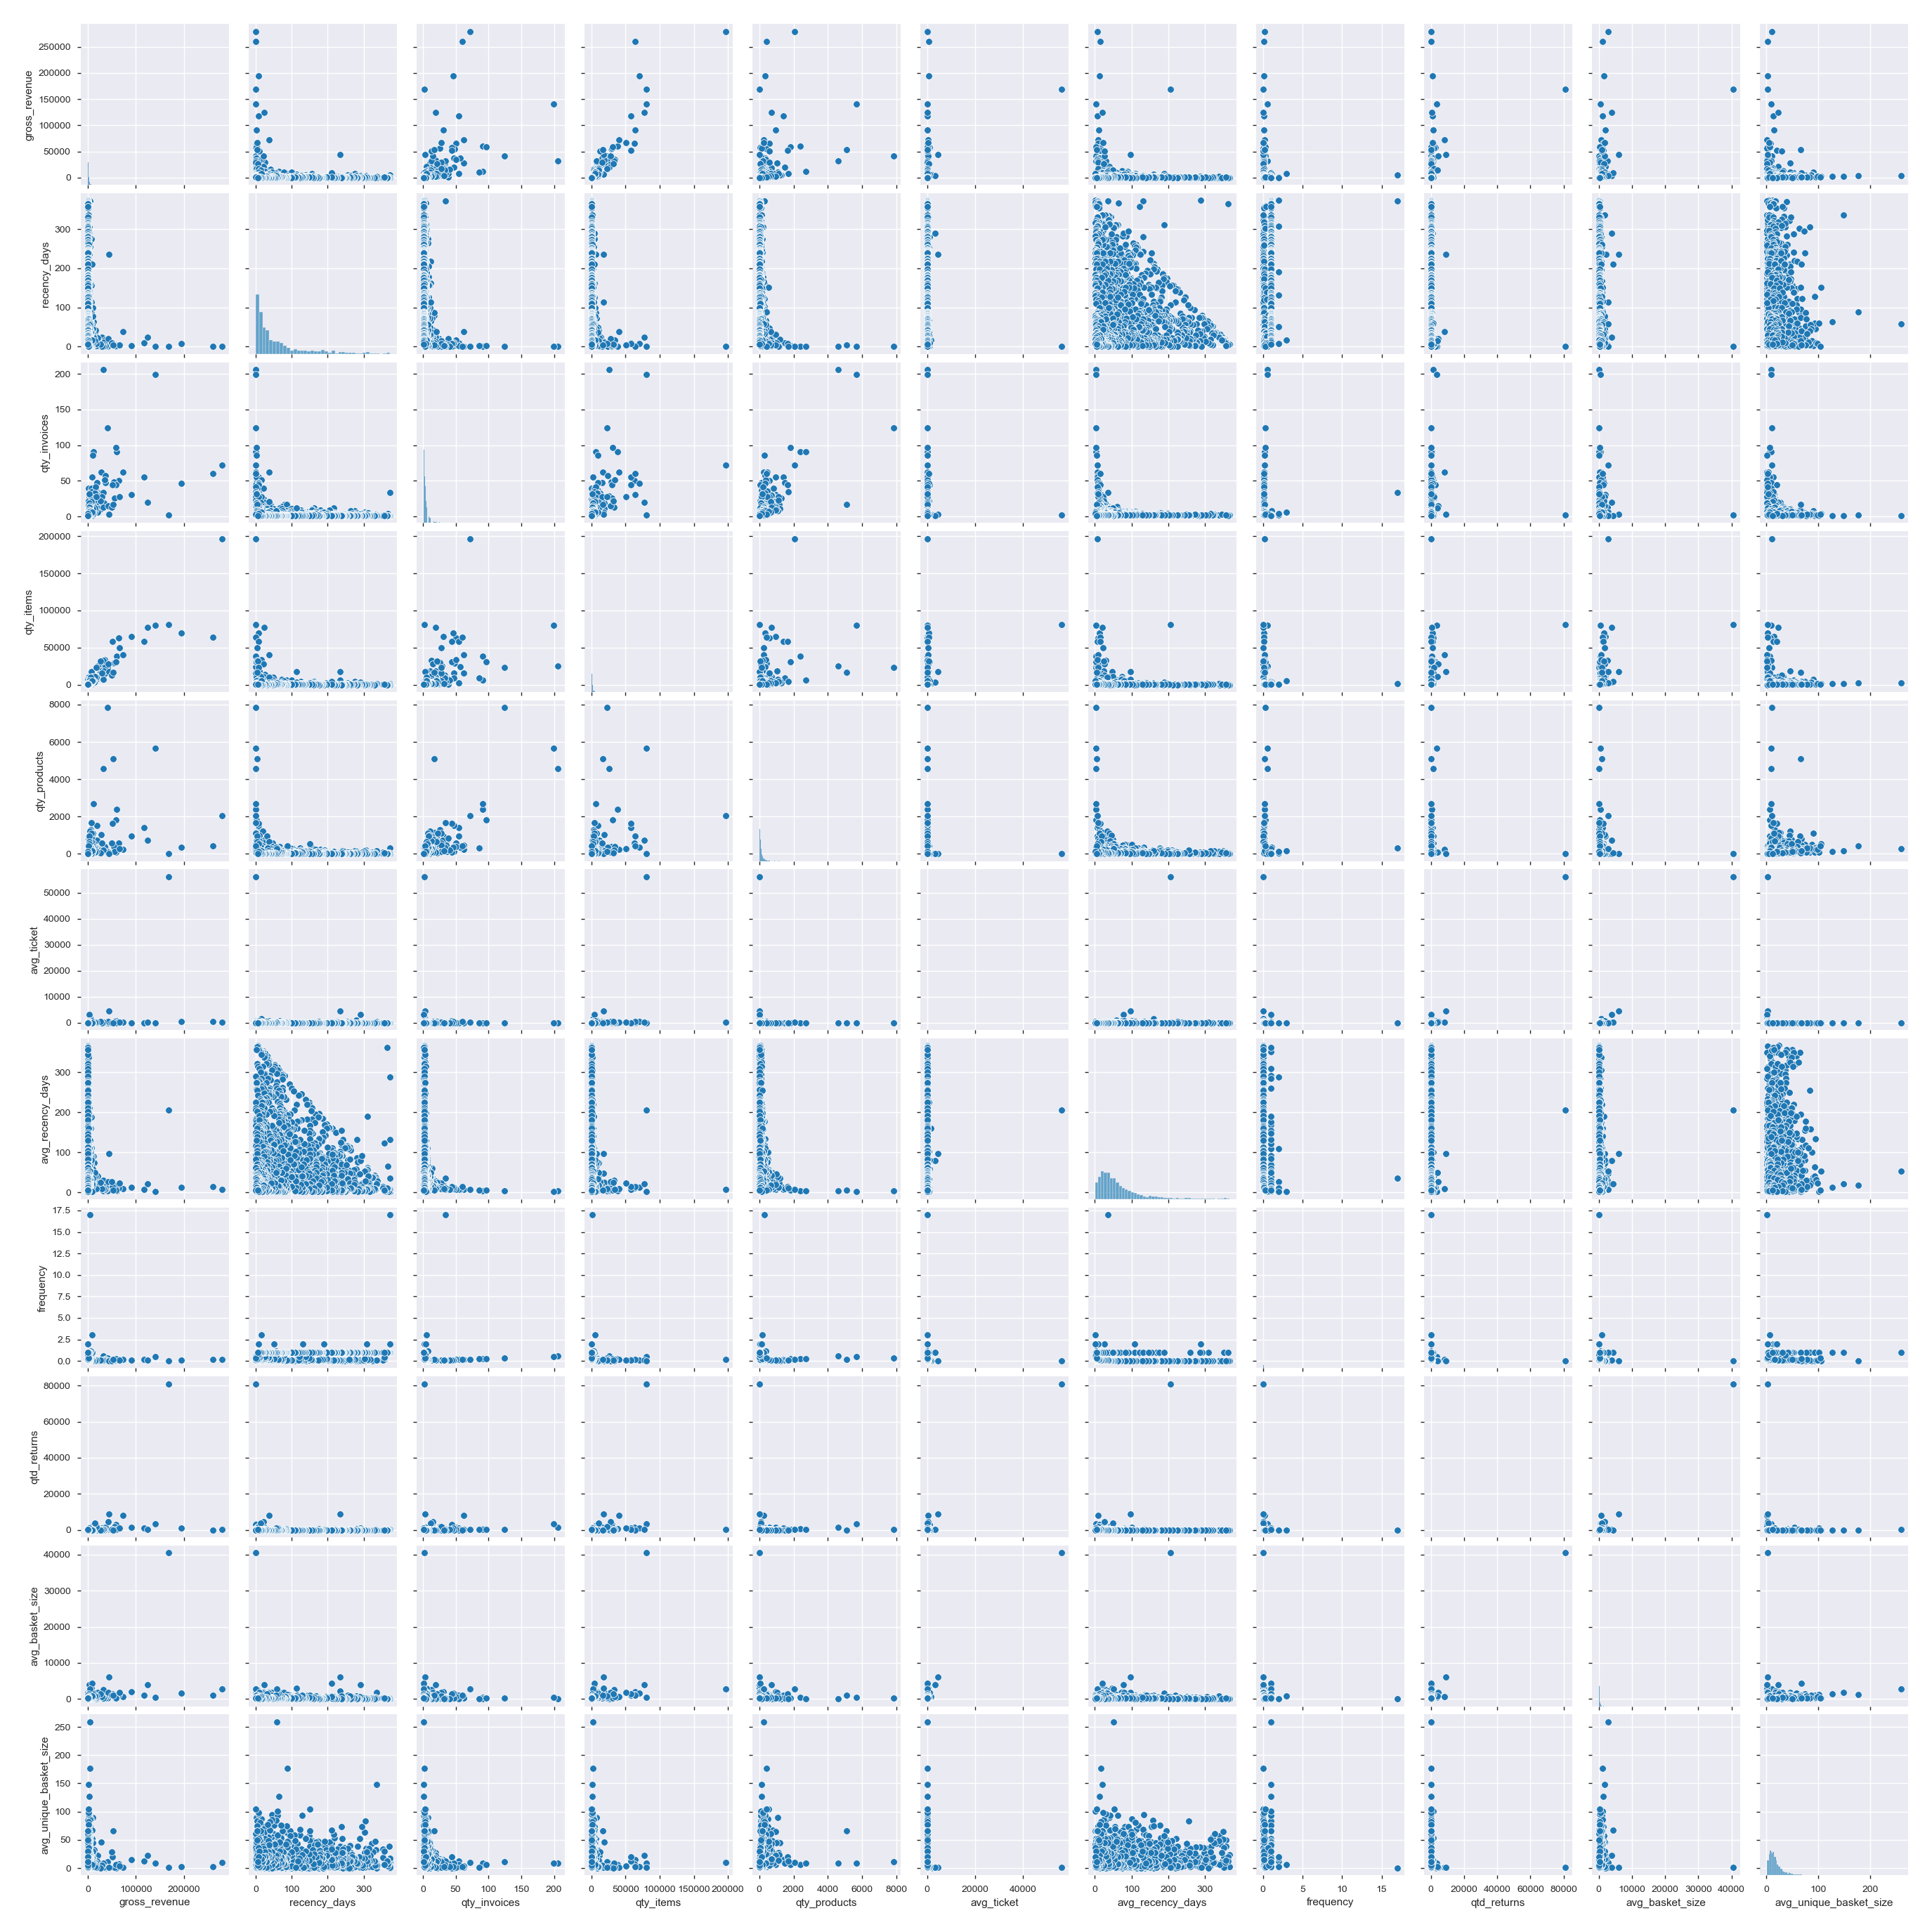

In [126]:
#cols = ['customer_id']
#df42 = df4.drop(cols, axis=1)

#plt.figure(figsize=(25,12))
#sns.pairplot(df42);
#plt.savefig('../reports/pairplot-c4.1.png')

Image('../reports/pairplot-c4.1.png')

# 5.0 Preparação dos dados

In [ ]:
df5 = df4.copy()

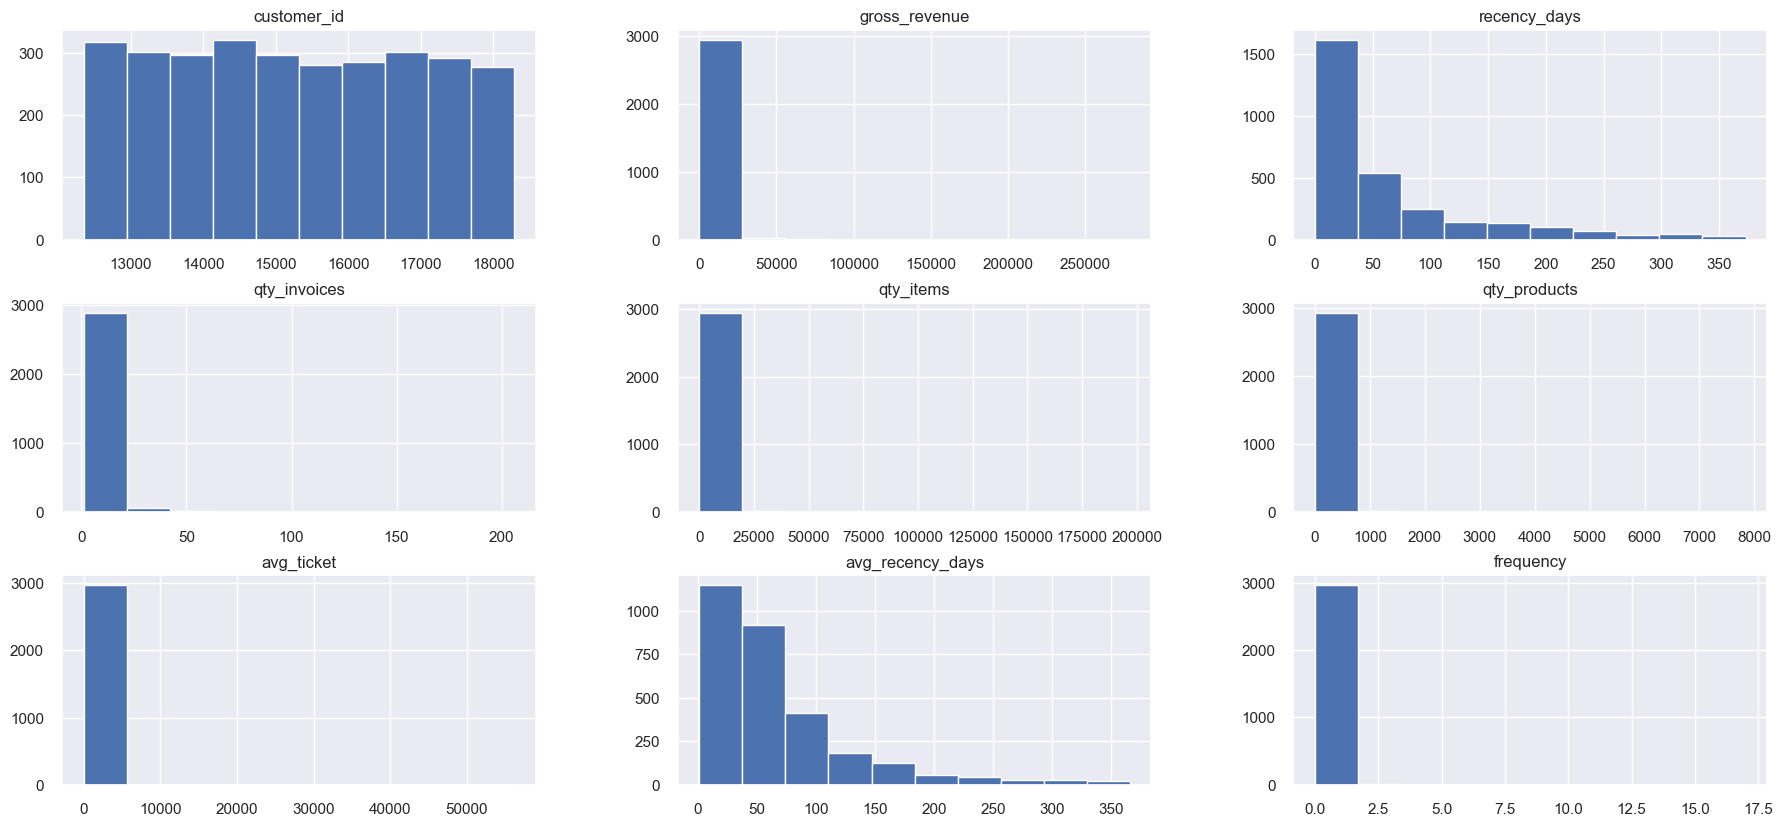

In [ ]:
df5.hist();

## 5.1 Normalização

## 5.2 Rescaling

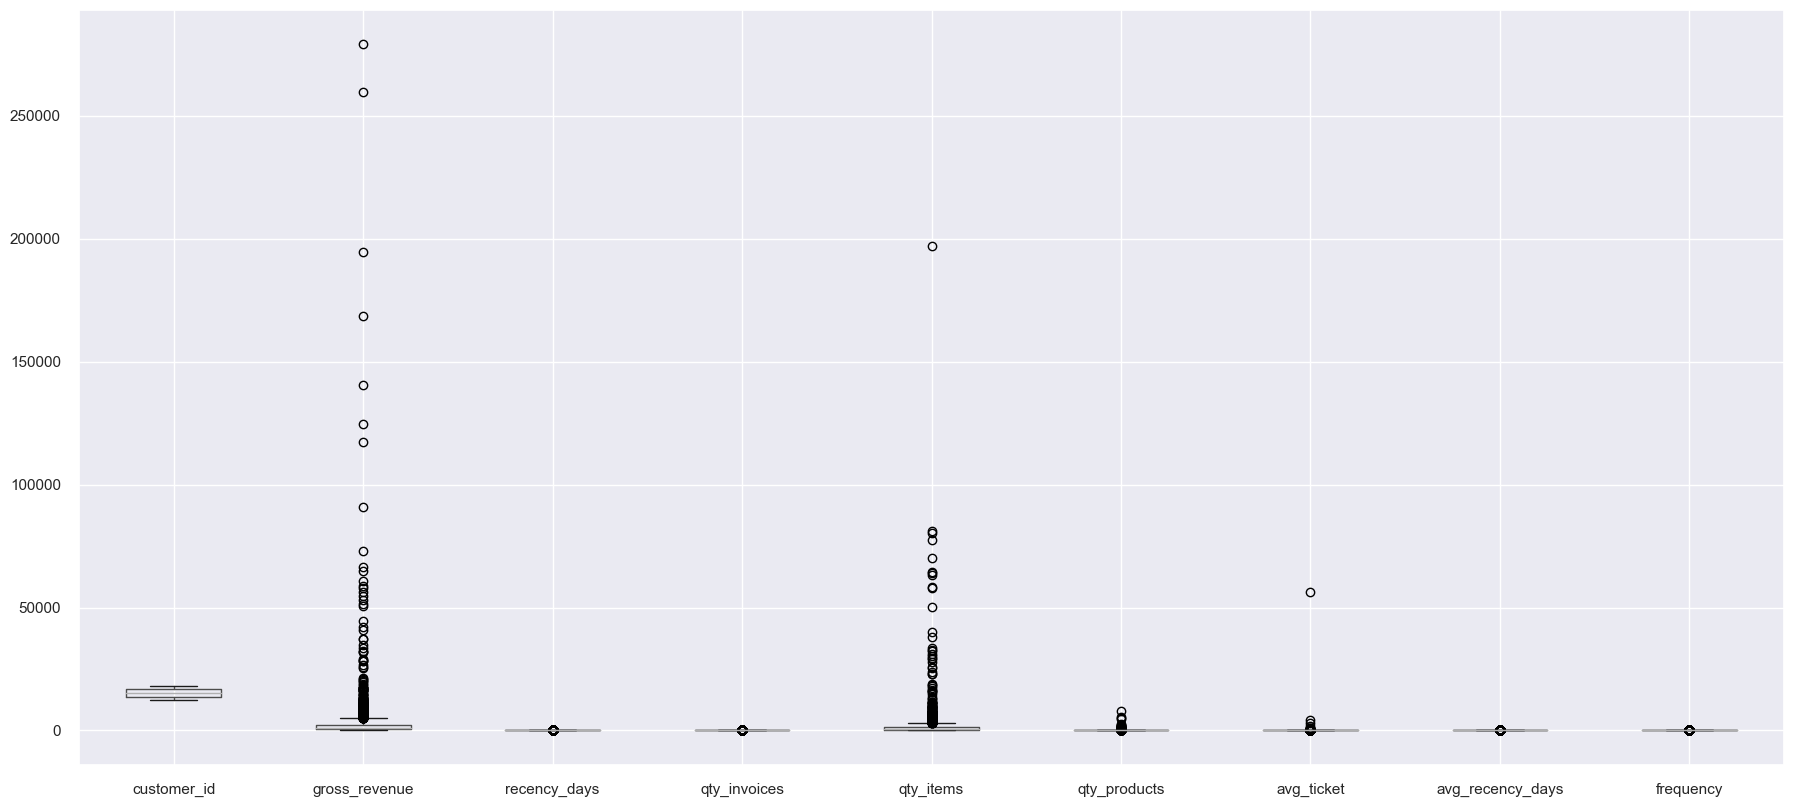

In [ ]:
df5.boxplot();

In [ ]:
df5.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency
0,17850,5391.210,372.000,34.000,1733.000,297.000,18.152,35.500,17.000
1,13047,3232.590,56.000,9.000,1390.000,171.000,18.904,27.250,0.028
2,12583,6705.380,2.000,15.000,5028.000,232.000,28.902,23.188,0.040
3,13748,948.250,95.000,5.000,439.000,28.000,33.866,92.667,0.018
4,15100,876.000,333.000,3.000,80.000,3.000,292.000,8.600,0.073


In [ ]:
rs = pp.RobustScaler()

df5['gross_revenue'] = rs.fit_transform(df5[['gross_revenue']].values)
df5['recency_days'] = rs.fit_transform(df5[['recency_days']].values)
df5['avg_ticket'] = rs.fit_transform(df5[['avg_ticket']].values)

df5['qty_invoices'] = rs.fit_transform(df5[['qty_invoices']].values)
df5['qty_items'] = rs.fit_transform(df5[['qty_items']].values)
df5['qty_products'] = rs.fit_transform(df5[['qty_products']].values)
df5['avg_recency_days'] = rs.fit_transform(df5[['avg_recency_days']].values)
df5['frequency'] = rs.fit_transform(df5[['frequency']].values)

## 5.3 Transformação

### 5.3.1 Encoding

### 5.3.3 Nature Transformation

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

## 6.2 Boruta as feature selector

## 6.3 Manual Feature Selection

# 7.0 Hyper Parameter Fine Tunning

In [ ]:
# drop customer id for ML train
X = df6.drop(columns=['customer_id'])
X

,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency
0,2.478,4.871,7.500,0.988,2.170,0.016,-0.215,512.648
1,1.235,0.357,1.250,0.678,0.981,0.080,-0.354,0.073
2,3.234,-0.414,2.750,3.970,1.557,0.922,-0.422,0.436
3,-0.080,0.914,0.250,-0.183,-0.368,1.340,0.747,-0.241
4,-0.121,4.314,-0.250,-0.508,-0.604,23.089,-0.668,1.428
...,...,...,...,...,...,...,...,...
5659,-0.353,-0.286,-0.750,-0.234,-0.349,-0.184,-0.745,29.420
5680,-0.219,-0.343,-0.250,-0.120,-0.491,2.453,-0.762,21.869
5686,0.003,-0.429,-0.250,0.083,3.472,-1.301,-0.737,8.279
5696,-0.452,-0.329,0.000,-0.343,0.500,-1.301,-0.796,59.622


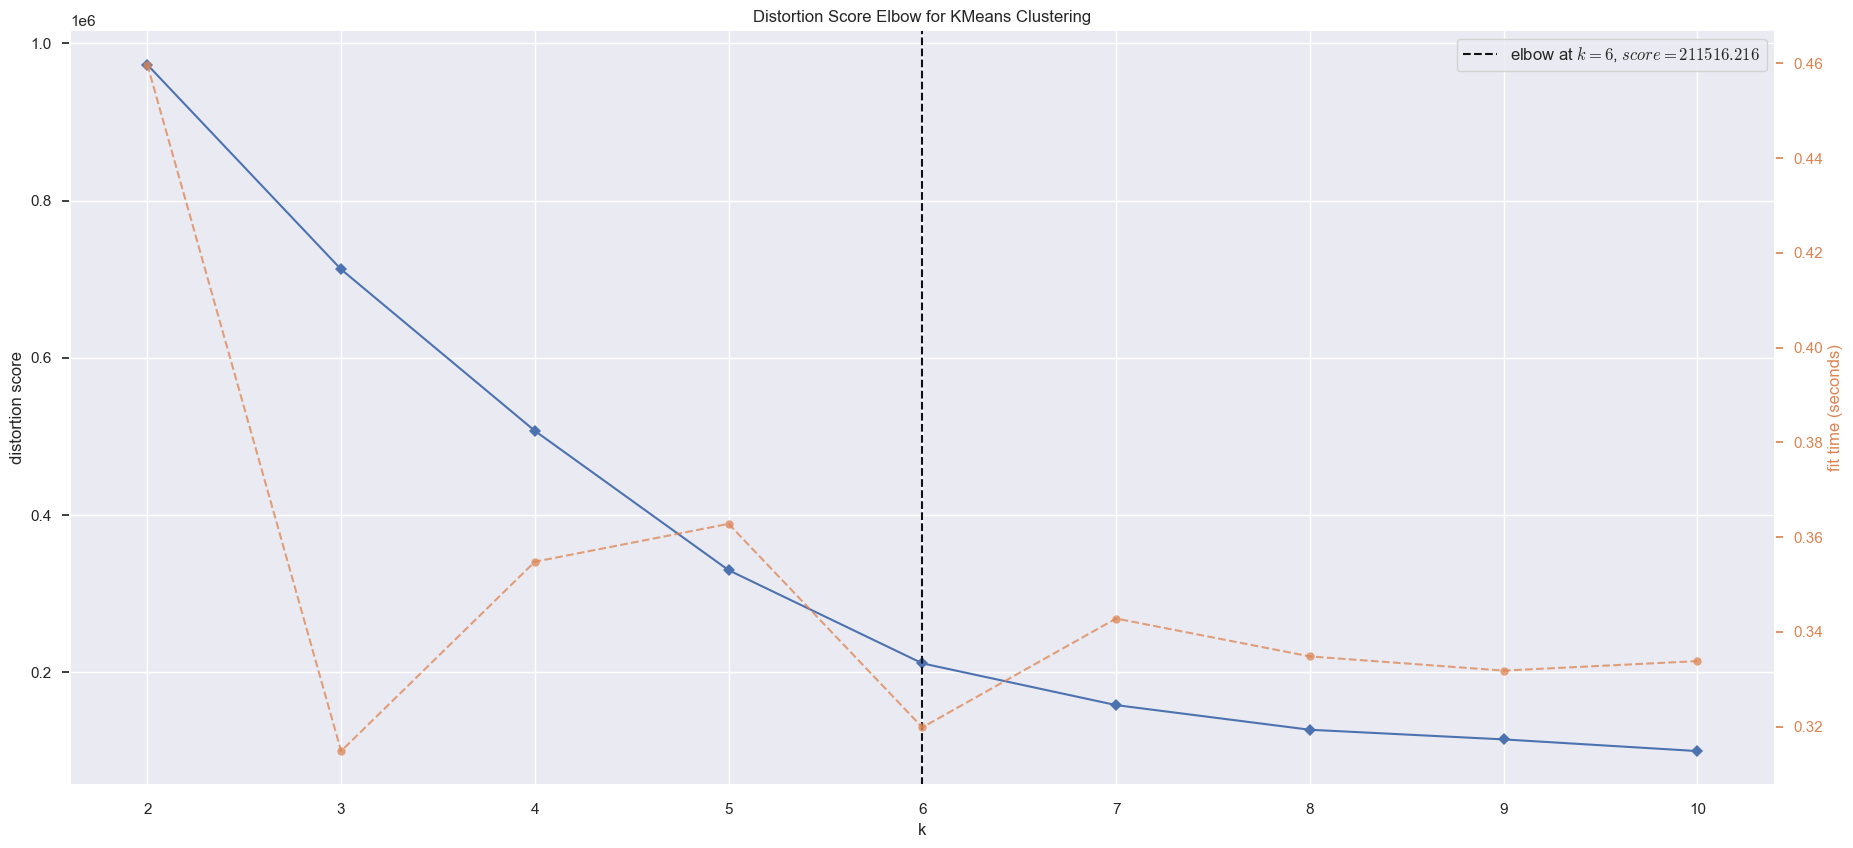

In [ ]:
# make search space for clusters
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Analysis metric - WSS (Within-Cluster Sum of Squares)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=True)
kmeans.fit(X)
kmeans.show();

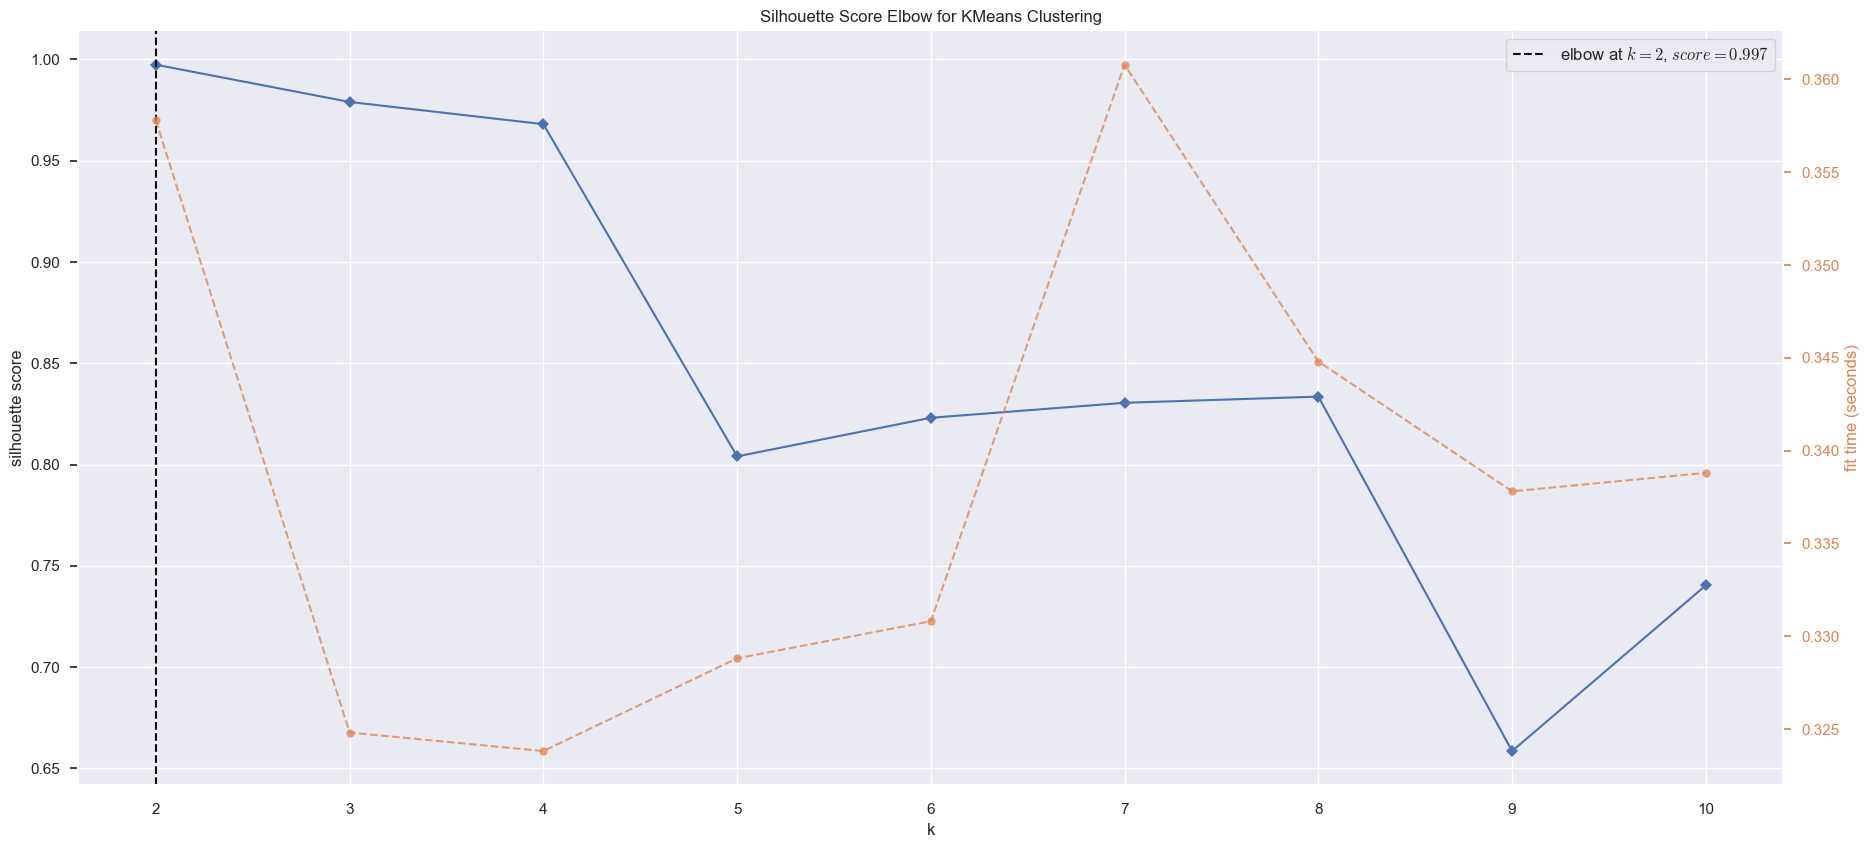

In [ ]:
# Analysis metric - SS (Silhouette score)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=True)
kmeans.fit(X)
kmeans.show();

## 7.1 Silhouette Analysis

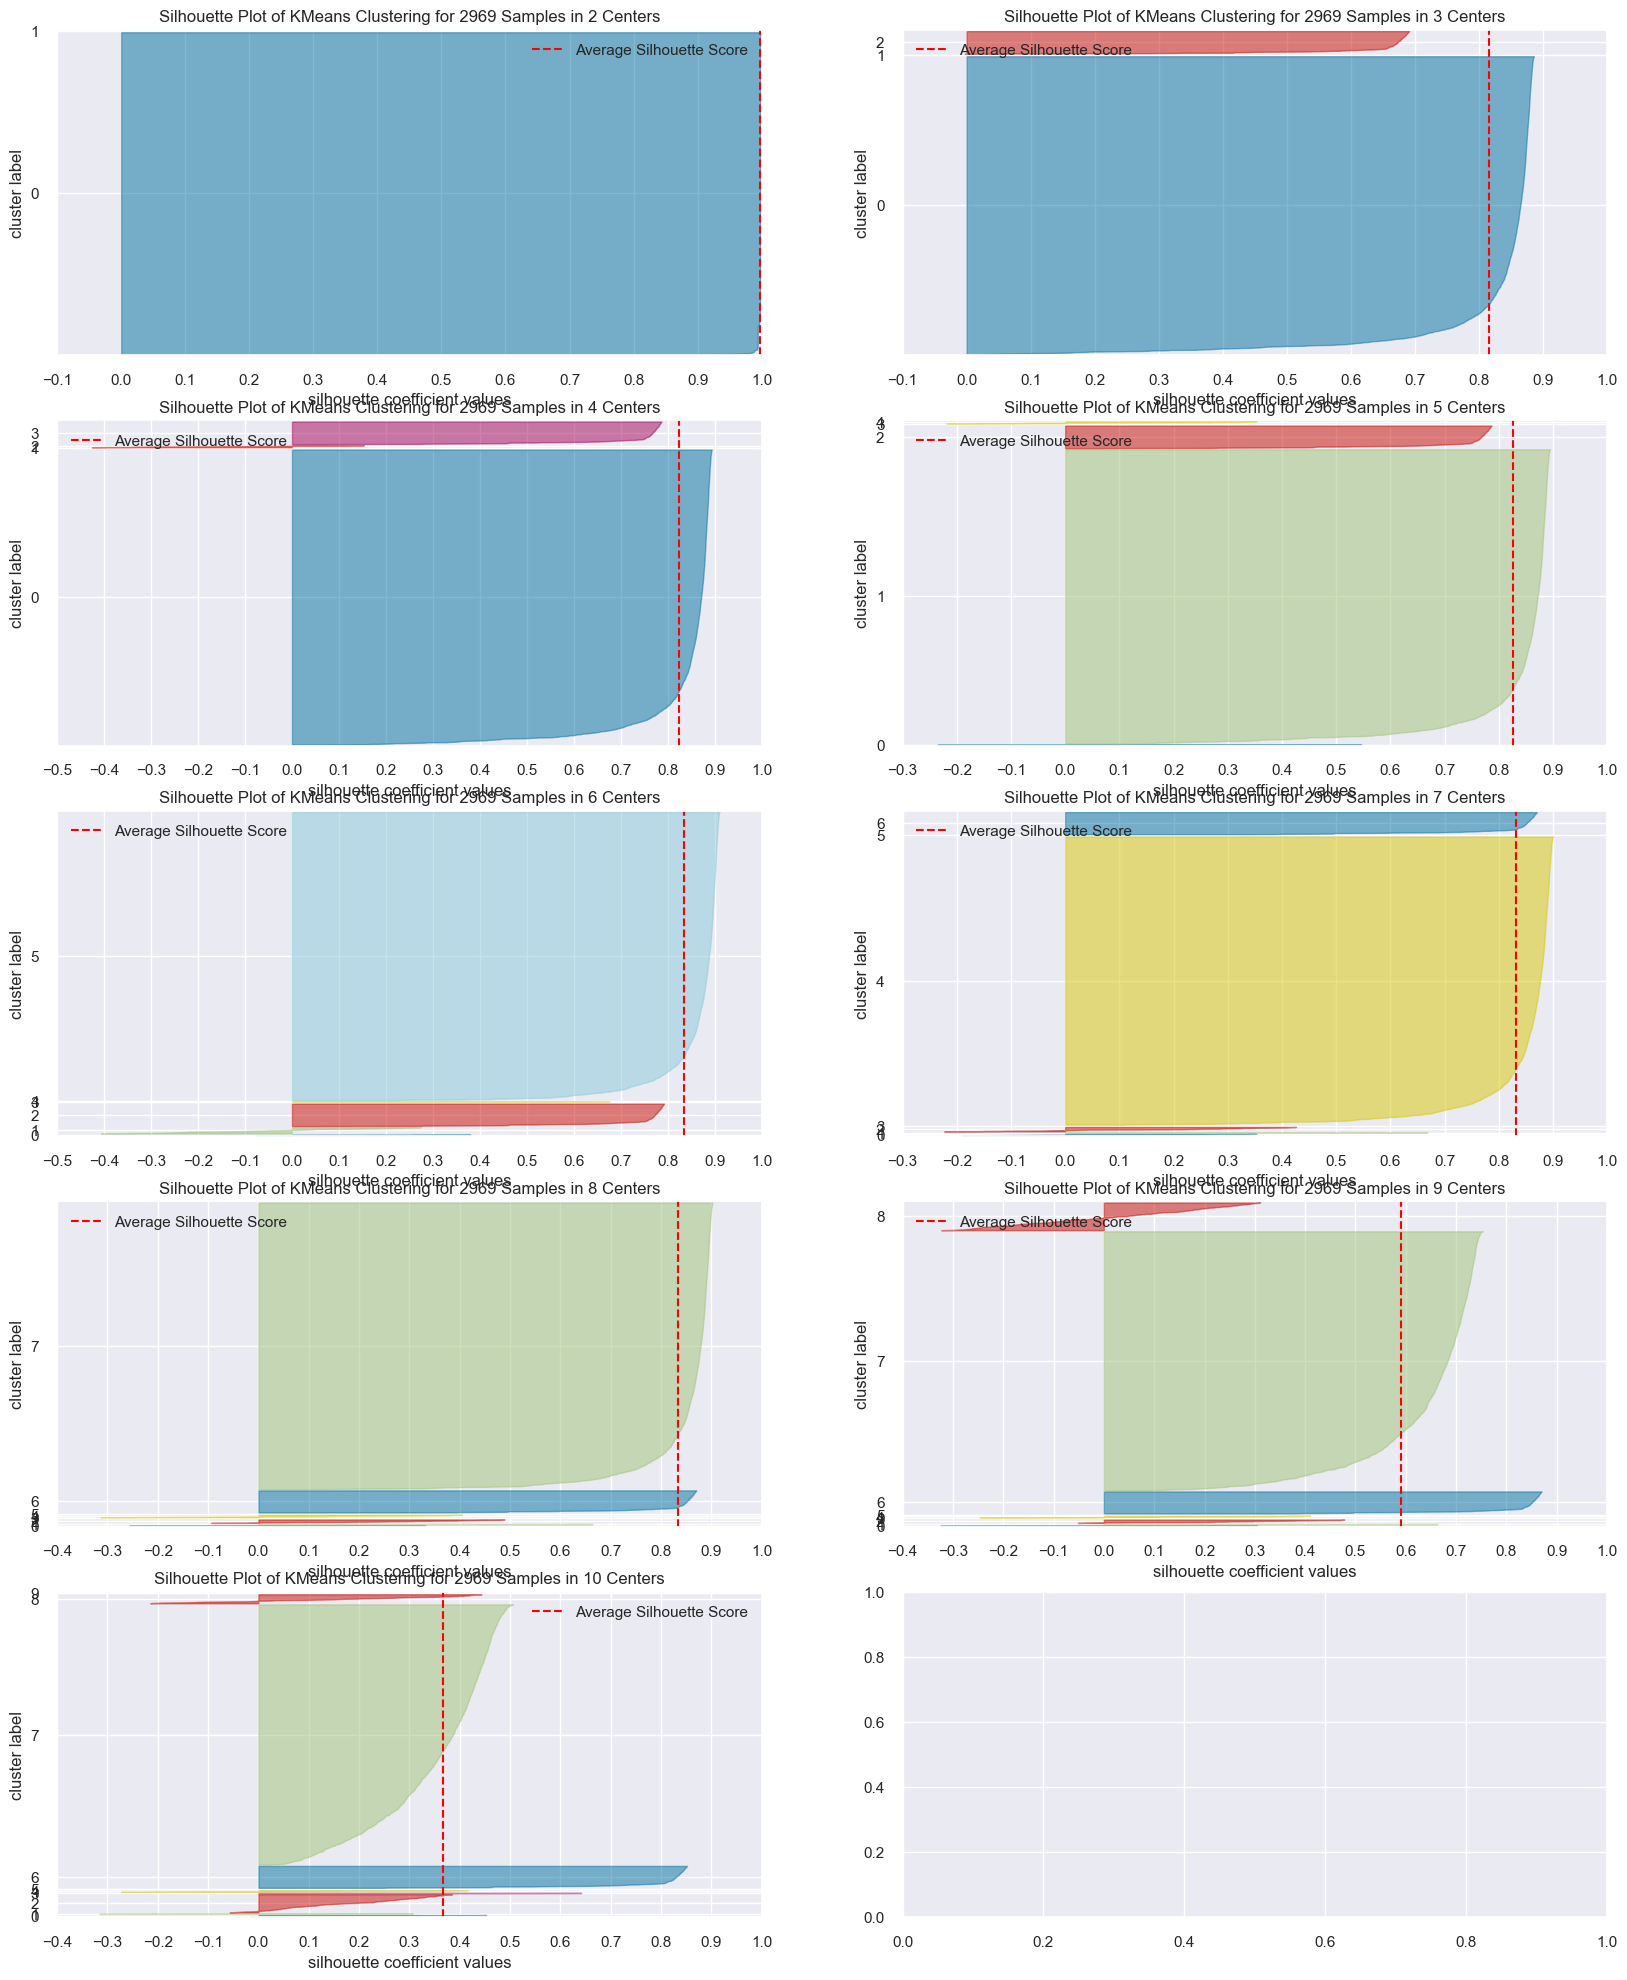

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(20,25))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0 Machine Learning Modeling

## 8.1 K-Means

In [ ]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [ ]:
# WSS (Within_cluster sum of square)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
SS = m.silhouette_score(X, labels)
print(f'SS Value: {SS}')

WSS Value: 598046.418571134
SS Value: 0.8246539262124557


## 8.6 Compare Model's Performance

### 8.6.2 Real Performance - Cross Validation

# 9.0 Cluster Analysis

In [ ]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,cluster
0,17850,5391.210,372.000,34.000,1733.000,297.000,18.152,35.500,17.000,0
1,13047,3232.590,56.000,9.000,1390.000,171.000,18.904,27.250,0.028,3
2,12583,6705.380,2.000,15.000,5028.000,232.000,28.902,23.188,0.040,3
3,13748,948.250,95.000,5.000,439.000,28.000,33.866,92.667,0.018,3
4,15100,876.000,333.000,3.000,80.000,3.000,292.000,8.600,0.073,3


## 9.1 Visualization Inspection

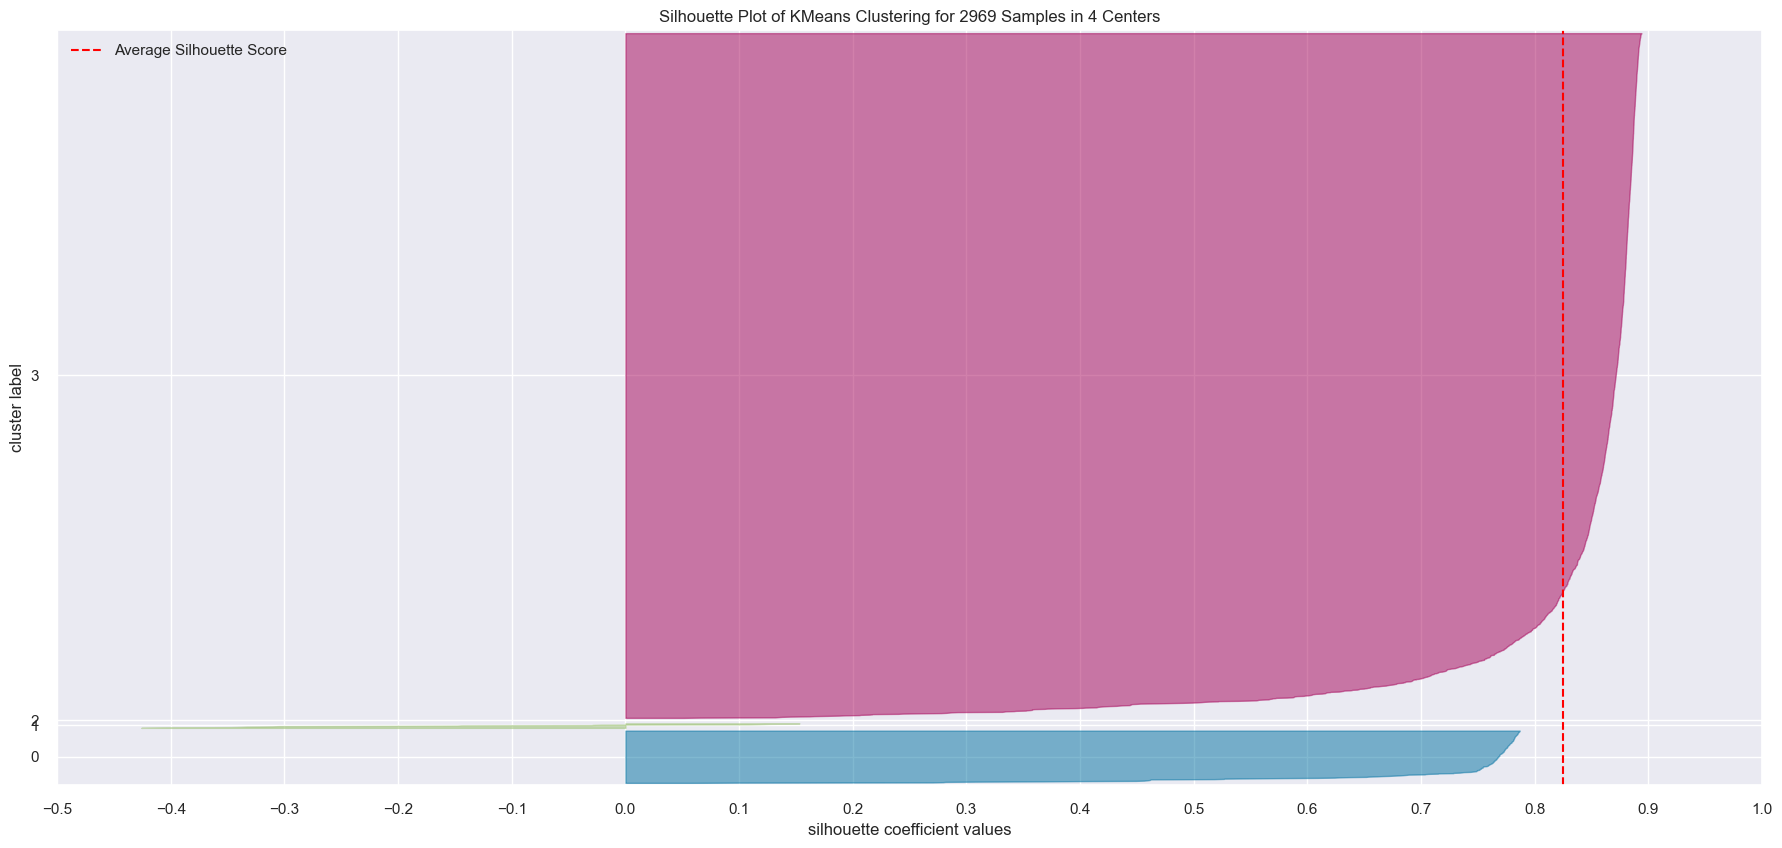

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2 2D Plot

In [ ]:
df_vis = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_vis, hue='cluster');

## 9.3 UMAP

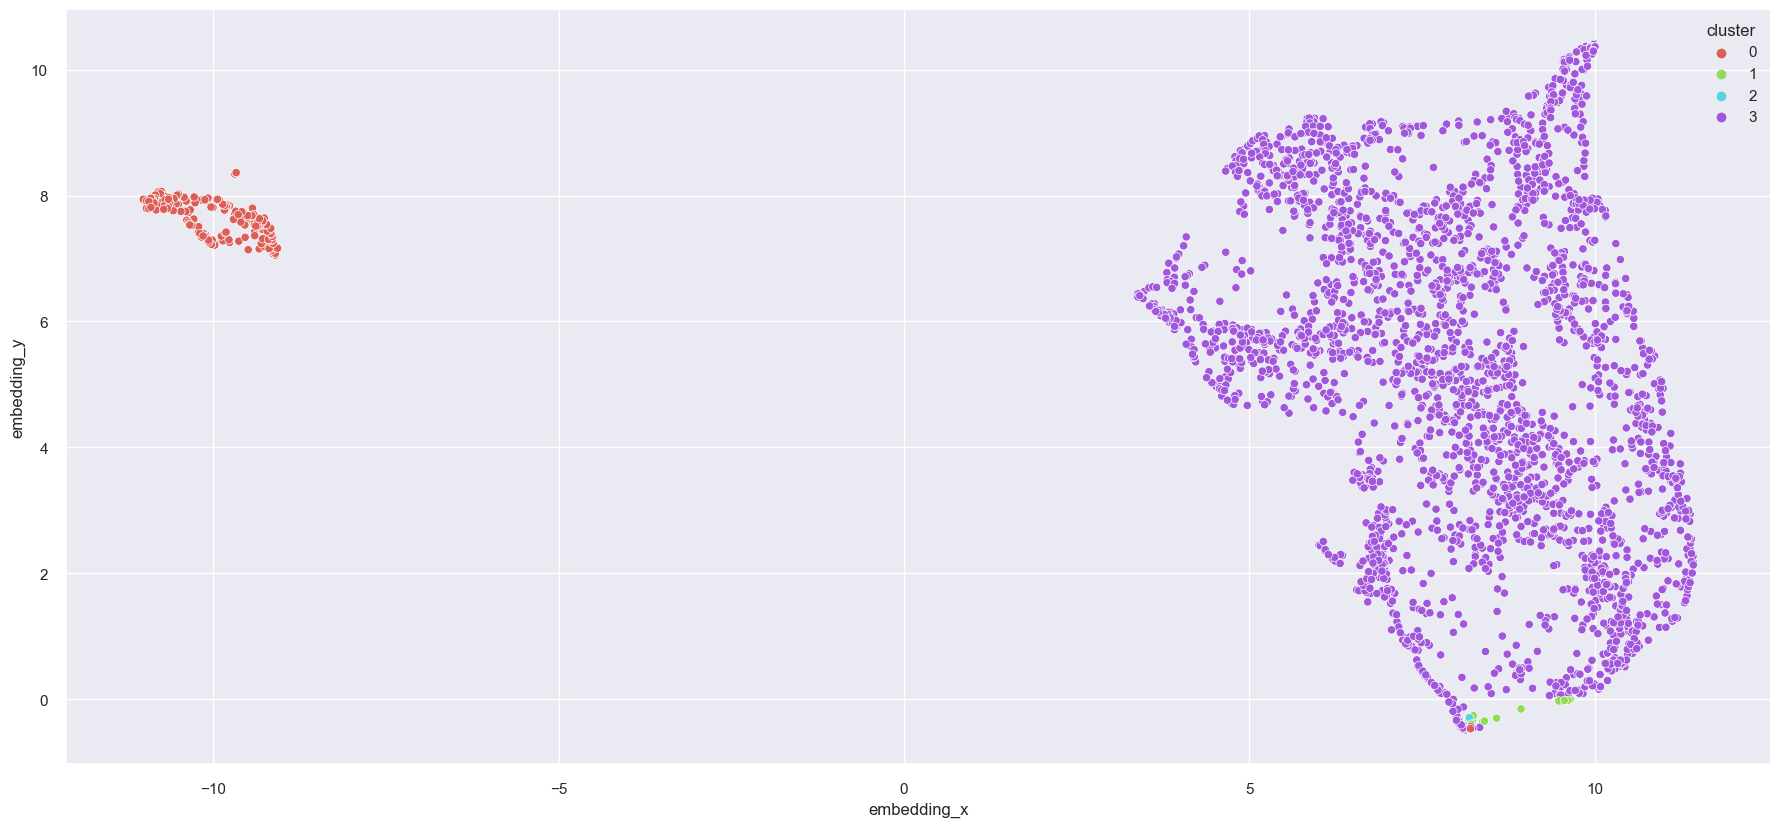

In [ ]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_vis['embedding_x'] = embedding[:,0]
df_vis['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_vis['cluster'].unique())), data=df_vis);

## 9.4 Cluster Profile

In [ ]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Frequency
df_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,210,7.073,620.458,169.057,1.109,32.334
1,1,19,0.640,87348.401,50.421,0.164,836.719
2,2,1,0.034,168472.500,0.000,0.010,56157.500
3,3,2739,92.253,2265.187,56.375,0.037,27.470


**Cluster 0:**

- Número de customer: 4.309 (99,51% dos customers)
- Recência em média: 92 dias
- Compras em média: 4 compras
- Receita em média: € 1.573,12
- Ticket médio: € 30,06

**Cluster 1:**

- Número de customer: 2 (0,04% dos customers)
- Recência em média: 162 dias
- Compras em média: 1 compras
- Receita em média: € 122.828,05
- Ticket médio: € 66.670,55

**Cluster 2: (Candidato a Insider)**

- Número de customer: 14 (0,32% dos customers)
- Recência em média: 7 dias
- Compras em média: 63 compras
- Receita em média: € 117.518,25
- Ticket médio: € 263,02

**Cluster 3:**

- Número de customer: 5 (0,11% dos customers)
- Recência em média: 181 dias
- Compras em média: 2 compras
- Receita em média: € 18.922,14
- Ticket médio: € 5.583,77

# 10.0 Deploy model to production